In [1]:
import tensorflow as tf
import keras
from keras.layers import Input ,Dense, Dropout, Activation, LSTM
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape, BatchNormalization, Add
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model
from keras.optimizers import Adam
from keras.engine.network import Network
from keras import backend as K

import keras.backend.tensorflow_backend as KTF

from keras.initializers import glorot_normal,orthogonal

from keras.callbacks import EarlyStopping,TensorBoard
import csv

from PIL import Image

%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import cv2
import os
import random

from tqdm import tqdm

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# sess = tf.Session(config=config)
# K.set_session(sess)


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#どんくらいで学習させるか関連
timesteps=10 #一回のLSTMに入れる値の数
camera=5 #カメラの数

rate = 5 #飛ばすフレーム数（30FPSを30/rateのFPSの動画に疑似変換する．）

#画像関連 
channels=3
img_width=50
img_height=50

#LSTMなどで用いる値
epochs = 100 # エポック数 
batch_size = 5 # バッチサイズ

In [3]:
class DataLoader:
    def __init__(self, camera_num, file_name, timesteps, width, height):
        self.camera_num = camera_num
        self.file_name =file_name
        self.samples=0
        self.timesteps=timesteps
        self.width=width
        self.height=height
        self.save_numpy()
        
    def save_numpy(self):
        self.samples = int(self.get_sample()/rate)
        if not (os.path.isfile(self.file_name+"label_"+str(rate)+".npy")):
            self.make_numpy_learnData()
            self.make_numpy_labelData()
        self.learnData=np.load(self.file_name+"learn_"+str(rate)+".npy")
        self.labelData=np.load(self.file_name+"label_"+str(rate)+".npy")
    
    def get_sample(self):
        video_path = self.file_name+"video/0.mp4"
        cap = cv2.VideoCapture(video_path)
        num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        return num
    
    def make_numpy_labelData(self):
        labelData=[]
        csv_selection=csv.reader(open(self.file_name+"video/mintime_optimize.csv", 'r'))
        one_hot = np.eye(self.camera_num)
        for i,row2 in enumerate(csv_selection):
            if(i%rate==0 and i > (self.timesteps-1)*rate-1):
                labelData.append(one_hot[int(row2[1])])
        tmp_list = np.array(labelData)
        tmp_list = tmp_list.astype(np.float)
        np.save(self.file_name+"label_"+str(rate)+".npy", tmp_list)
        print(tmp_list.shape)
    
    
    def make_numpy_learnData(self):
        learnData=[]
        for i in range(0, self.camera_num):
            print()
            img_list=[]
            video_path = self.file_name+"video/"+str(i)+".mp4"
            cap = cv2.VideoCapture(video_path)
            video_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            for j in range(0,video_len):
                
                pro_size=20
                bar = int(j*pro_size/video_len)
                pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
                percent ='{:03f}'.format(j / video_len * 100.)
                print('\r{0}/{1} [{2}] {3}%'.format((i+1), self.camera_num, pro_bar, percent), end='')
                
                ret, frame = cap.read()
                if(j%rate==0):
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    img=Image.fromarray(frame)
                    img = img.resize((self.width, self.height))
                    x = np.array(img, dtype=np.float32)
                    x = x / 255.
                    img_list.append(x)
            learnData.append(img_list)
            
        tmp_list=np.array(learnData)
        tmp_list=tmp_list.astype(np.float)
        np.save(self.file_name+"learn_"+str(rate)+".npy", tmp_list)
        print(tmp_list.shape)
    
    
    def make_learndata(self, num=[]):
        data_name=self.file_name+"learn_0_"+str(rate)+".npy"
        if (os.path.isfile(data_name)):
            test=np.load(data_name)
        else:
            all_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
            tmp_list = [np.empty((0,self.timesteps, self.width, self.height, 3), np.float)]*self.camera_num
            for i in range(0, self.labelData.shape[0]):
                #まずはすべての分だけ回す
                pro_size=20
                bar = int(i*pro_size/self.labelData.shape[0])
                pro_bar = ('=' * bar) + (' ' * (pro_size - bar))
                percent ='{:03f}'.format(i / self.labelData.shape[0] * 100.)
                print('\r [{0}] {1}%'.format(pro_bar, percent), end='')
                
                count=num[np.argmax(self.labelData[i,:])]
                
                for j in range(0,count):
                    #dataAugumentationする分だけ回す
                    #dataAugmentationは異なるカメラでも同じ時間軸の場合同じ角度で回したいため，はじめに角度を取得する．
                    random_angle = float(random.randint(0,180))
                    
                    for camera in range(0, self.camera_num):
                        #カメラの台数だけ回す
                        #tmp_list[camera]の同じ引数（番号）には角度を同じ分だけずらした同じ時間軸のsequenceが入っている．
                        first_list =np.empty((0, self.width, self.height, 3), np.float)
                        for l in range(0, self.timesteps):
                            #timesteps分のndarrayを作る．
                            tmp_img=self.learnData[camera,i+l]
                            img = self.augumentation(tmp_img, random_angle)
                            first_list =np.append(first_list, [img], axis=0)
                        #あるカメラについて，１つのsequenceがfirst_listに出来上がっている状態．
                        tmp_list[camera]=np.append(tmp_list[camera], [first_list], axis=0)
                if(tmp_list[0].shape[0]>100 or i == self.labelData.shape[0]-1):
                    #処理時間短縮のため，sequenceがtmp_listに溜まってきたら，全体に統合してまたtmp_listを初期化する．
                    for camera in range(0, self.camera_num):
                        all_list[camera]=np.append(all_list[camera], tmp_list[camera], axis=0)
                        tmp_list[camera] = np.empty((0,self.timesteps, self.width, self.height, 3), np.float)
            
            for camera in range(0, self.camera_num):
                print(all_list[camera].shape)
                data_name=self.file_name+"learn_"+str(camera)+"_"+str(rate)
                np.save(data_name, all_list[camera])
                del all_list[camera]
    
    
    def make_labeldata(self, num=[]):
        data_name=self.file_name+"final_label_"+str(rate)+"_.npy"
        if (os.path.isfile(data_name)):
            test=np.load(data_name)
        else:
            test = np.empty((0,5), np.float)
            for i in range(0,self.labelData.shape[0]):
                count=num[np.argmax(self.labelData[i,:])]
                for j in range(0, count):
                    test = np.append(test, [self.labelData[i]], axis=0)
            print(test.shape)
            np.save(data_name, test)
    
    
    def get_learndata(self, num):
        data_name=self.file_name+"learn_"+str(num)+"_"+str(rate)+".npy"
        test=np.load(data_name)
        return test
    
    def get_labeldata(self):
        data_name=self.file_name+"final_label_"+str(rate)+"_.npy"
        test=np.load(data_name)
        return test
    
    
    def augumentation(self, img, num):
        height = img.shape[0]                
        width = img.shape[1]                       
        center = (int(width/2), int(height/2))
        angle = num
        scale = 1.0
        trans = cv2.getRotationMatrix2D(center, angle , scale)
        image2 = cv2.warpAffine(img, trans, (width,height))
        return image2
        
    
    def show(self):
        print(0,self.get_learndata(0).shape)
        print(1,self.get_learndata(1).shape)
        print(2,self.get_learndata(2).shape)
        print(3,self.get_learndata(3).shape)
        print(4,self.get_learndata(4).shape)
        print(self.get_labeldata().shape)

In [4]:
data = DataLoader(camera, "./data/20190426/", timesteps, img_width, img_height)
aug_rate=[3,7,7,2,1]
data.make_learndata(aug_rate)
data.make_labeldata(aug_rate)
data.show()

0 (1687, 10, 50, 50, 3)
1 (1687, 10, 50, 50, 3)
2 (1687, 10, 50, 50, 3)
3 (1687, 10, 50, 50, 3)
4 (1687, 10, 50, 50, 3)
(1687, 5)


In [5]:
### add for TensorBoard

old_session = KTF.get_session()
session = tf.Session('')
KTF.set_session(session)
KTF.set_learning_phase(1)

In [6]:
class Resnet18 :
    ##
    ##　Resnet-18の作成
    ##
    def __init__(self, width, height, channels):
        self.img_rows=height
        self.img_cols=width
        self.img_channels=channels
    
    def rescell(self, data, filters, kernel_size, option=False):
        strides=(1,1)
        if option:
            strides=(2,2)
        x=Convolution2D(filters=filters,kernel_size=kernel_size,strides=strides,padding="same")(data)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        
        data=Convolution2D(filters=int(x.shape[3]), kernel_size=(1,1), strides=strides, padding="same")(data)
        x=Convolution2D(filters=filters,kernel_size=kernel_size,strides=(1,1),padding="same")(x)
        x=BatchNormalization()(x)
        x=Add()([x,data])
        x=Activation('relu')(x)
        
        return x
    
    def create_resnet18(self):
        inputs=Input(shape=(self.img_rows, self.img_cols, self.img_channels))
        x=Convolution2D(64,(7,7), padding="same", input_shape=(self.img_rows, self.img_cols),activation="relu")(inputs)
        x=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

        x=self.rescell(x,64,(3,3))
        x=self.rescell(x,64,(3,3))
        x=self.rescell(x,64,(3,3))
        
        x=self.rescell(x,128,(3,3),True)
        x=self.rescell(x,128,(3,3))

        x=self.rescell(x,256,(3,3),True)
        x=self.rescell(x,256,(3,3))
        
        x=self.rescell(x,512,(3,3),True)
        x=self.rescell(x,512,(3,3))
        
        model=Model(inputs=inputs,outputs=[x])
        return model

    def get_resnet18(self):
        return self.create_resnet18()

In [12]:
class Prediction :
    def __init__(self, timesteps, n_out, width, height):
        self.maxlen = timesteps
        self.n_out = n_out
        self.width=width
        self.height=height
        self.resnet = Resnet18(width, height, 3).get_resnet18()
        self.sharedLayer = self.create_sharedmodel()
    
    
    def create_sharedmodel(self):
        inputs = Input(shape=(self.maxlen, self.height, self.width, 3))
        
        x = TimeDistributed(self.resnet,name="resnet")(inputs)
        x = TimeDistributed(GlobalAveragePooling2D(), name="GAP")(x)
        x = TimeDistributed(Dense(512,activation='relu'), name="dense")(x)
        predictions = LSTM(256, batch_input_shape = (None, self.maxlen, 512),
             kernel_initializer = glorot_normal(seed=20181020),
             recurrent_initializer = orthogonal(gain=1.0, seed=20181020), 
             dropout = 0.01, 
             recurrent_dropout = 0.01)(x)
        
        shared_layers = Model(inputs, predictions, name="shared_layers")
        
        return shared_layers
    
    
    def create_model(self):
        model_input1 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input2 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input3 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input4 = Input(shape=(self.maxlen, self.height, self.width, 3))
        model_input5 = Input(shape=(self.maxlen, self.height, self.width, 3))
        
        mid_feature1 = self.sharedLayer(model_input1)
        mid_feature2 = self.sharedLayer(model_input2)
        mid_feature3 = self.sharedLayer(model_input3)
        mid_feature4 = self.sharedLayer(model_input4)
        mid_feature5 = self.sharedLayer(model_input5)
        
        merged_vector = keras.layers.concatenate([mid_feature1, mid_feature2, mid_feature3, mid_feature4, mid_feature5], axis=-1)
        mid_dense = Dense(256, activation='relu')(merged_vector)
        predictions = Dense(self.n_out, activation='softmax')(mid_dense)
        
        model = Model(inputs=[model_input1, model_input2, model_input3, model_input4, model_input5], outputs=predictions)
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    
    def train(self, x_train, t_train, x_vali, t_vali, batch_size, epochs) :
        early_stopping = EarlyStopping(patience=20, verbose=1)
        tb_cb = TensorBoard(log_dir="./data/20190426/tflog/", histogram_freq=1)
        model = self.create_model()
        hist = model.fit(x=[x_train[0], x_train[1], x_train[2], x_train[3], x_train[4]], y=t_train, batch_size = batch_size, epochs = epochs, validation_data=([x_vali[0], x_vali[1], x_vali[2], x_vali[3], x_vali[4]], t_vali), callbacks = [early_stopping])
        return model, hist
    
    
    def train_keras(self, x_train, t_train, batch_size, epochs) :
        early_stopping = EarlyStopping(patience=20, verbose=1)
        tb_cb = TensorBoard(log_dir="./data/20190426/tflog/", histogram_freq=1, write_graph=True, write_grads=True)
        model = self.create_model()
        hist = model.fit([x_train[0], x_train[1], x_train[2], x_train[3], x_train[4]], t_train, batch_size = batch_size, epochs = epochs, verbose = 1,
                         callbacks = [early_stopping], validation_split = 0.2)
        return model, hist

In [13]:
# モデル定義
pred = Prediction(timesteps, camera, img_width, img_height)
model = pred.create_model()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 10, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 10, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 10, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 10, 50, 50, 3 0                                            
__________________________________________________________________________________________________
input_24 (

In [14]:
from tqdm import tqdm
test_learn=[np.empty((data.get_labeldata().shape[0],10, 50, 50, 3), np.float)]*camera
vali_learn=[np.empty((0,10, 50, 50, 3), np.float)]*camera
test_label=data.get_labeldata()
vali_label=np.empty((0,camera), np.float)

print(test_label.shape)

for j in range(0,camera):
    test_learn[j]=data.get_learndata(j)

# for i in tqdm(range(0,int(0.1*test_label.shape[0]))):
#     random_angle = int(random.randint(0,test_label.shape[0]-1))
#     for j in range(0,camera):
#         vali_learn[j]=np.append(vali_learn[j], [test_learn[j][random_angle]],axis=0)
#         test_learn[j]=np.delete(test_learn[j], random_angle,0)
#     vali_label=np.append(vali_label, [test_label[random_angle]], axis=0)
#     test_label=np.delete(test_label, random_angle,0)

(1687, 5)


In [15]:
# 学習
#model , hist = pred.train(test_learn, test_label, vali_learn, vali_label, batch_size, epochs)
model , hist = pred.train_keras(test_learn, test_label, batch_size, epochs)
# テスト
score = model.evaluate(test_learn, test_label, batch_size = batch_size, verbose = 1)
print("score:", score)


# ### add for TensorBoard
# KTF.set_session(old_session)
# ###


# -------------------------------------------------------------------------------------
#                            モデルのアーキテクチャの保存
# -------------------------------------------------------------------------------------
# モデルのアーキテクチャの保存①(JSON版)
model_arc_json = model.to_json()
open("model_architecture.json", mode='w').write(model_arc_json)


# -------------------------------------------------------------------------------------
#                            　　モデルの重みの保存
# -------------------------------------------------------------------------------------
# モデルの重みの保存
model.save_weights("weights.hdf5")

Train on 1349 samples, validate on 338 samples
Epoch 1/100
1349/1349 [==============================] - 106s 79ms/step - loss: 0.4669 - acc: 0.8013 - val_loss: 0.5232 - val_acc: 0.7781
Epoch 2/100
1349/1349 [==============================] - 73s 54ms/step - loss: 0.3495 - acc: 0.8458 - val_loss: 0.4925 - val_acc: 0.7817
Epoch 3/100
1349/1349 [==============================] - 74s 55ms/step - loss: 0.2607 - acc: 0.8895 - val_loss: 0.5291 - val_acc: 0.7503
Epoch 4/100
1349/1349 [==============================] - 75s 55ms/step - loss: 0.1814 - acc: 0.9293 - val_loss: 0.8295 - val_acc: 0.7047
Epoch 5/100
1349/1349 [==============================] - 74s 55ms/step - loss: 0.1432 - acc: 0.9440 - val_loss: 0.7446 - val_acc: 0.7325
Epoch 6/100
1349/1349 [==============================] - 75s 56ms/step - loss: 0.1088 - acc: 0.9617 - val_loss: 0.8477 - val_acc: 0.7201
Epoch 7/100
1349/1349 [==============================] - 74s 55ms/step - loss: 0.0849 - acc: 0.9663 - val_loss: 0.8595 - val_acc: 

FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Attempting to use uninitialized value batch_normalization_20/moving_variance
	 [[node batch_normalization_20/moving_variance (defined at /home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[conv2d_46/bias/_213]]
  (1) Failed precondition: Attempting to use uninitialized value batch_normalization_20/moving_variance
	 [[node batch_normalization_20/moving_variance (defined at /home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'batch_normalization_20/moving_variance':
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-e4d0cf8ca60e>", line 2, in <module>
    pred = Prediction(timesteps, camera, img_width, img_height)
  File "<ipython-input-12-5505ac52b853>", line 7, in __init__
    self.resnet = Resnet18(width, height, 3).get_resnet18()
  File "<ipython-input-6-c4d559fb421e>", line 48, in get_resnet18
    return self.create_resnet18()
  File "<ipython-input-6-c4d559fb421e>", line 31, in create_resnet18
    x=self.rescell(x,64,(3,3))
  File "<ipython-input-6-c4d559fb421e>", line 20, in rescell
    x=BatchNormalization()(x)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/keras/layers/normalization.py", line 129, in build
    trainable=False)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/keras/engine/base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 258, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 219, in _variable_v1_call
    shape=shape)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 197, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/variable_scope.py", line 2519, in default_variable_creator
    shape=shape)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 262, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 1688, in __init__
    shape=shape)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py", line 1846, in _init_from_args
    shape, self._initial_value.dtype.base_dtype, name=name)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/state_ops.py", line 79, in variable_op_v2
    shared_name=shared_name)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_state_ops.py", line 1621, in variable_v2
    shared_name=shared_name, name=name)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/kei666/anaconda3/envs/lstm/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


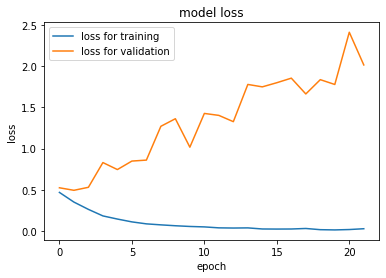

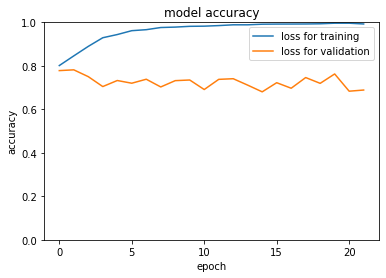

In [16]:
def plot_history_loss(hist):
    # 損失値(Loss)の遷移のプロット
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

def plot_history_acc(hist):
    # 精度(Accuracy)の遷移のプロット
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

In [20]:
#試すやつ！

pre = [[0 for i in range(5)] for j in range(5)]
print(test_learn[0].shape)
# 正答率集計
preds = model.predict([test_learn[0], test_learn[1], test_learn[2], test_learn[3], test_learn[4]])
correct = 0

f = open("./data/20190426/result.csv", 'w')
writer = csv.writer(f)
for i in range(0,timesteps):
    writer.writerow([0])
        
for i in range(len(preds)):
    pred_result = np.argmax(preds[i,:])
    tar = np.argmax(data.get_labeldata()[i,:])
    for j in range(0,rate):
        writer.writerow([pred_result])
    pre[pred_result][tar]+=1
    print(pred_result, tar)
    if pred_result == tar :
        correct += 1

print("正答率:", 1.0 * correct / len(preds))

(1687, 10, 50, 50, 3)


FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Attempting to use uninitialized value batch_normalization_24/beta
	 [[{{node batch_normalization_24/beta/read}}]]
	 [[dense_12/Softmax/_307]]
  (1) Failed precondition: Attempting to use uninitialized value batch_normalization_24/beta
	 [[{{node batch_normalization_24/beta/read}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
a = [0,0,0,0,0]
for i in range(0, 742):
    tar = np.argmax(data.get_labeldata()[i,:])
    a[tar]=a[tar]+1
print(a)

In [12]:
print(test_learn[0].shape)
print(vali_learn[0].shape)
print(test_label.shape)
print(vali_label.shape)

(1519, 10, 50, 50, 3)
(168, 10, 50, 50, 3)
(1519, 5)
(168, 5)


In [ ]:
print(tf.__version__) # 1.5.0